# Kish Basin Salt Caverns

<https://hyss.ie/>

In [1]:
import glob
import itertools
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import shapely
from geocube.api.core import make_geocube
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# base data directory
DATA_DIR = os.path.join("data", "kish-basin")

crs = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[1][:-4]]["data"] = (
            os.path.split(dat_file)[1][:-4]
        )

    # find data resolution
    gdf_xr = (
        gdf[os.path.split(dat_file)[1][:-4]].set_index(["X", "Y"]).to_xarray()
    )
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    ds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # keep only points corresponding to zones of interest in the dataframe
    zones = gdf.loc[gdf["data"].str.contains("Zone")]

    # create zones of interest polygon
    zones = gpd.GeoDataFrame(geometry=zones.buffer(100).envelope).dissolve()

    # create extent polygon
    extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (extent[" X"][0], extent[" Y"][0]),
            (extent[" X"][1], extent[" Y"][1]),
            (extent[" X"][2], extent[" Y"][2]),
            (extent[" X"][3], extent[" Y"][3])
        ]),
        crs=crs
    )

    return ds, zones, extent

In [4]:
ds, zones, extent = read_dat_file(DATA_DIR, dat_crs=crs)

### Halite layers

In [5]:
ds

<xarray.Dataset>
Dimensions:      (data: 19, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
  * data         (data) <U66 'Flyde Halite Base Depth XYZ Meters' ... 'Rossal...
    spatial_ref  int64 0
Data variables:
    Z            (data, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [6]:
ds.rio.crs

CRS.from_epsg(23029)

In [7]:
ds.rio.resolution()

(200.0, -200.0)

In [8]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

### Zones of interest boundaries

In [9]:
zones

,geometry
0,"MULTIPOLYGON (((701700.000 5899700.000, 701700..."


In [10]:
zones.bounds

,minx,miny,maxx,maxy
0,697900.0,5894100.0,726900.0,5929500.0


In [11]:
# use extent bounds
xmin, ymin, xmax, ymax = extent.total_bounds

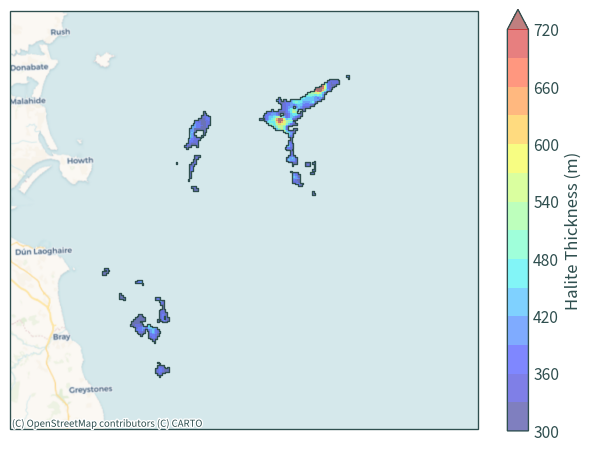

In [12]:
ax = plt.axes(projection=ccrs.epsg(crs))
zones.boundary.plot(color="darkslategrey", linewidth=1, ax=ax)
ds.sel(
    data=[x for x in ds["data"].values if "Zone" in x]
).max(dim="data")["Z"].plot(
    cmap="jet",
    alpha=.5,
    levels=15,
    robust=True,
    cbar_kwargs={"label": "Halite Thickness (m)"},
    xlim=(xmin, xmax),
    ylim=(ymin, ymax)
)
cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager, zoom=10)
plt.title(None)
plt.tight_layout()
plt.show()

### Generate potential salt cavern locations

In [13]:
def generate_caverns(diameter, separation):
    """
    Generate salt caverns using a regular grid within the zones of interest
    based on the methodology by Caglayan et al. (2020)
    """

    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + separation, separation):
        for y0 in np.arange(ymin, ymax + separation, separation):
            # bounds
            x1 = x0 - separation
            y1 = y0 + separation
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    grid_cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

    # verify separation distance
    x0 - x1 == y1 - y0

    # generate caverns within the zones of interest
    caverns = gpd.sjoin(
        gpd.GeoDataFrame(geometry=grid_cells.centroid.buffer(diameter / 2)),
        zones,
        predicate="within"
    )

    # estimations based on Caglayan et al. (2020)
    print("Number of potential caverns:", len(caverns))
    print(
        "Total volume:",
        "{:.2E}".format(len(caverns) * 5e5), f"m\N{SUPERSCRIPT THREE}"
    )
    print(
        "Estimated storage capacity:",
        "{:.2f}".format(len(caverns) * 146.418), "GWh"
    )

    return caverns

In [14]:
def plot_map(data, cbar_label):
    """
    Plot halite layer and caverns within the zones of interest
    """

    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(crs))

    data["Z"].plot.contourf(
        cmap="jet",
        alpha=.65,
        robust=True,
        levels=15,
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        cbar_kwargs={"label": cbar_label}
    )
    caverns.centroid.plot(
        ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
    )
    cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=.25, color="darkslategrey"
    )
    ax.add_artist(ScaleBar(
        1, box_alpha=0,  # font_properties={"size": "large"},
        location="lower right", color="darkslategrey"
    ))
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05), markerscale=1.75)
    plt.title("Potential Kish Basin Caverns within Zones of Interest")
    plt.tight_layout()
    plt.show()

#### 84 m diameter, separation distance of 4 times the diameter (Caglayan et al., 2020)

In [15]:
caverns = generate_caverns(84, 84 * 4)

Number of potential caverns: 281
Total volume: 1.40E+08 m³
Estimated storage capacity: 41143.46 GWh


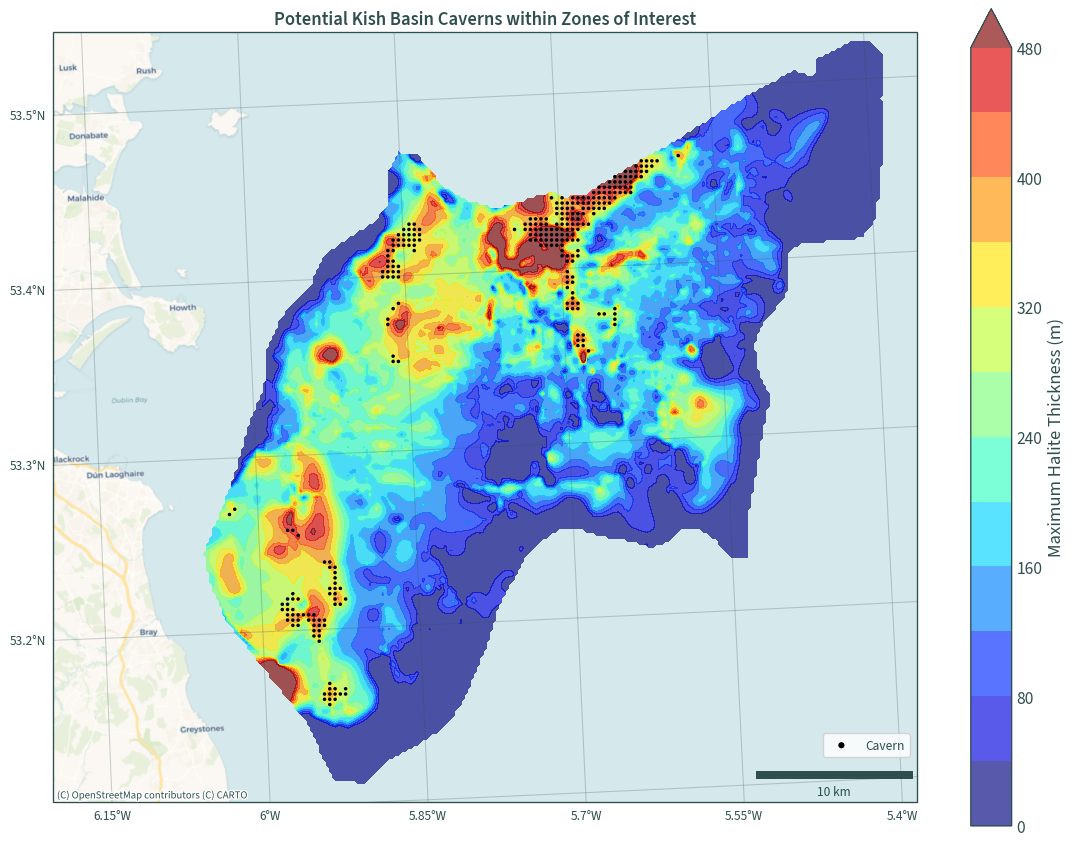

In [16]:
plot_map(
    ds.sel(
        data=[x for x in ds["data"].values if "Thickness XYZ" in x]
    ).max(dim="data"),
    "Maximum Halite Thickness (m)"
)

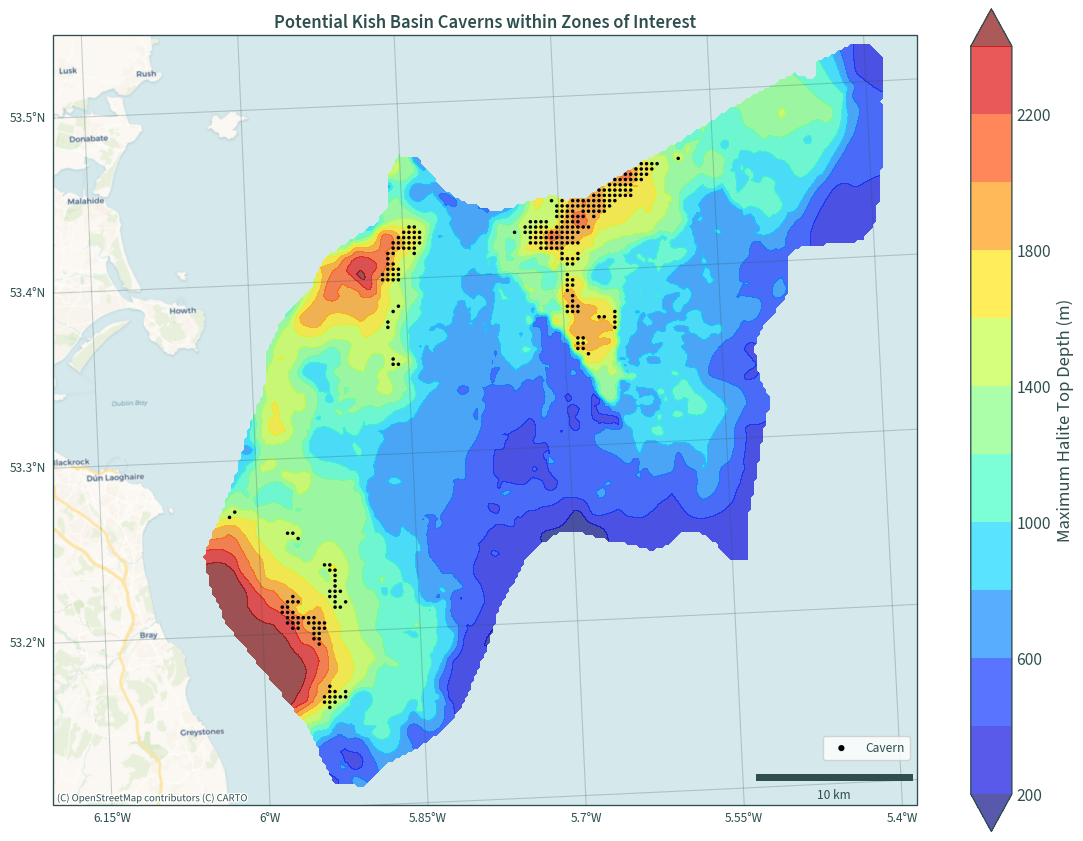

In [17]:
plot_map(
    ds.sel(
        data=[x for x in ds["data"].values if "Top Depth" in x]
    ).max(dim="data"),
    "Maximum Halite Top Depth (m)"
)

#### 85 m diameter, 330 m separation (used in initial calculations by HYSS)

In [18]:
caverns = generate_caverns(85, 330)

Number of potential caverns: 314
Total volume: 1.57E+08 m³
Estimated storage capacity: 45975.25 GWh
